# Order of magnitude faster training for image classification: Part II

### _Transfer learning using Inception Package - Cloud Run Experience_
This notebook continues the codifies the capabilities discussed in this [blog post](http://localhost:8081/). In a nutshell, it uses the pre-trained inception model as a starting point and then uses transfer learning to train it further on additional, customer-specific images. For explanation, simple flower images are used. Compared to training from scratch, the time and costs are drastically reduced.

This notebook does preprocessing, training and prediction by calling CloudML API instead of running them in the Datalab container.  The purpose of local work is to do some initial prototyping and debugging on small scale data - often by taking a suitable (say 0.1 - 1%) sample of the full data. The same basic steps can then be repeated with much larger datasets in cloud.

## Setup 

First run the following steps only if you are running Datalab from your local desktop or laptop (not running Datalab from a GCE VM):

1. Make sure you have a GCP project which is enabled for Machine Learning API and Dataflow API.
2. Sign in with Datalab on the top right corner.
3. Run "%projects set [project-id]" to set the default project in Datalab.
4. Run "!gcloud config set project [project-id]"

Then, regardless of where you run Datalab, please run:

!gcloud beta ml init-project -q

In [3]:
!gcloud beta ml init-project -q

Added serviceAccount:cloud-ml-service@datalab-beta-golden-83755.iam.gserviceaccount.com as an Editor to project 'datalab-beta-golden'.


In [2]:
bucket = 'gs://' + datalab_project_id() + '-lab'
preprocess_dir = bucket + '/flowerpreprocessed'
model_dir = bucket + '/flowermodel'

In [3]:
!gsutil mb $bucket

Creating gs://bradley-playground-lab/...


## Preprocess
Preprocessing uses a Dataflow pipeline to convert the image format, resize images, and run the converted image through a pre-trained model to get the features or embeddings. You can also do this step using alternate technologies like Spark or plain Python code if you like. 
The %%ml preprocess command simplifies this task. Check out the parameters shown using --usage flag first and then run the command.

If you hit "PERMISSION_DENIED" when running the following cell, you need to enable Cloud DataFlow API (url is shown in error message). 

The DataFlow job usually takes about 20 min to complete.

In [4]:
%ml preprocess --package gs://cloud-datalab/packages/inception-0.1.tar.gz --cloud
input_csvs:
  - gs://cloud-datalab/sampledata/flower/train1000.csv
output_dir: $preprocess_dir
pipeline_option:
  num_workers: 8

Job submitted. Click here to track preprocessing job.

## Train
Note that the command remains the same as that in the "local" version. Added option `--cloud` ensures that it is run using CloudML

In [3]:
%ml train --package gs://cloud-datalab/packages/inception-0.1.tar.gz --cloud
input_dir: $preprocess_dir
region: us-central1
max_steps: 1000
batch_size: 100
output_dir: $model_dir

Job submitted. Click here to view cloud log.

## Predict
Deploy the model and run online predictions. For now you need to append "/model" to the model dir. The deployment takes about 2 ~ 5 minutes. 

In [3]:
%mlalpha deploy --name inception.beta1 --path $model_dir

Waiting for job "projects/bradley-playground/operations/create_inception_beta1-1485371381178"
Done.


Online prediction is currently in alpha, it helps to ensure a warm start if the first call fails.

Predicting...


daisy(0.99881)

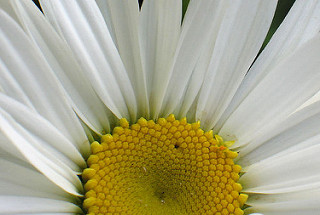

tulips(0.99912)

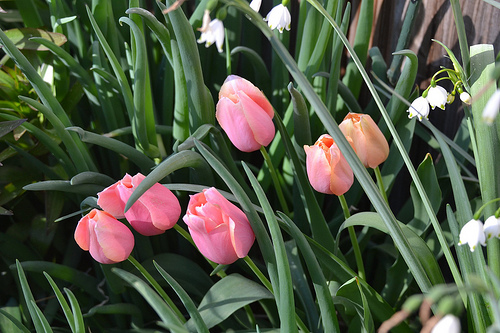

In [6]:
%ml predict --package gs://cloud-datalab/packages/inception-0.1.tar.gz --cloud
image_files: 
  - gs://cloud-ml-data/img/flower_photos/daisy/15207766_fc2f1d692c_n.jpg
  - gs://cloud-ml-data/img/flower_photos/tulips/6876631336_54bf150990.jpg
model_id: inception.beta1

In [8]:
%mlalpha model --name inception

deploymentUri,lastUseTime,name,isDefault,createTime
gs://datalab-beta-golden-lab/flowermodel/model,2017-01-24T19:52:46Z,projects/datalab-beta-golden/models/inception/versions/beta1,True,2017-01-24T19:38:14Z
